# Проект: классификация

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly.express as px

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

Целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её необходимо предсказать.

### Задание 1

In [69]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')

In [70]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum().sort_values(ascending=False)

balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

### Задание 2

In [71]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
print(df['job'].nunique())
print(df['job'].unique())
print(df['job'].value_counts())

12
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64


### Задание 3

In [72]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace(',00','')
df['balance'] = df['balance'].str.replace('$','')
df['balance'] = df['balance'].str.replace(' ','')
df['balance']= df['balance'].astype('float64')
print('Среднее по столбцу баланс:', round(df['balance'].mean(), 3))

Среднее по столбцу баланс: 1529.129


### Задание 4

In [73]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
print('Среднее по признаку balance:', round(df['balance'].mean(), 3))

Среднее по признаку balance: 1526.936


### Задание 5

In [74]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df_job = df['job'].mode()[0]
df_edu = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: df_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df_edu if x == 'unknown' else x)
print(round(df[(df['education']=='secondary') & (df['job']=='management')]['balance'].mean(),3))

1598.883


### Задание 6

In [75]:
# удалите все выбросы для признака balance

# Поиск выбросов по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, upper_bound, lower_bound

outliers, df, upper_bound, lower_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')
print(f'Верхняя граница: {upper_bound} Нижняя граница: {lower_bound}')


Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Верхняя граница: 4063.0 Нижняя граница: -2241.0


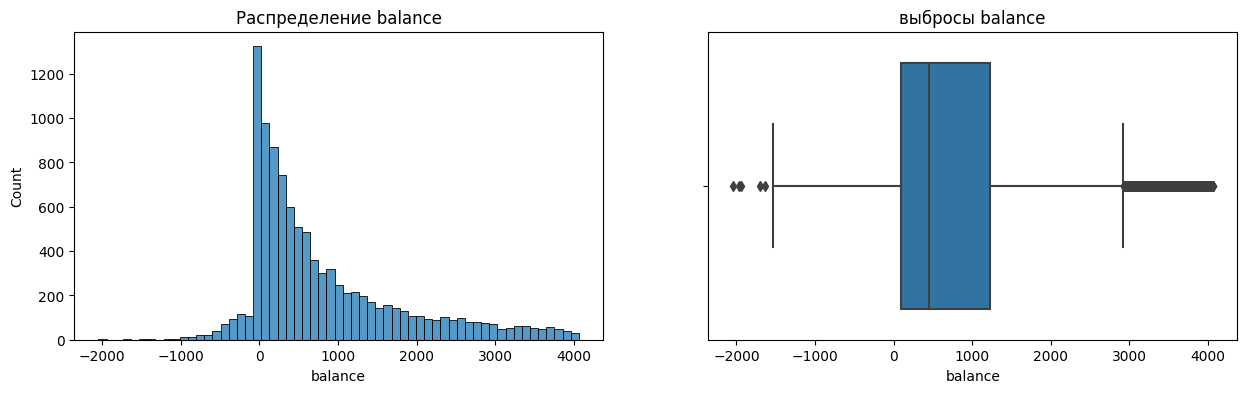

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Распределение balance');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('выбросы balance');

## Часть 2:  Разведывательный анализ

### Задание 1

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

<AxesSubplot: xlabel='deposit', ylabel='count'>

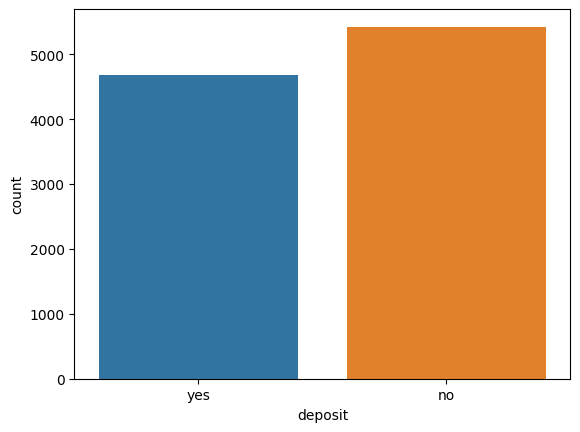

In [77]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(df['deposit'].value_counts(normalize=True))
sns.countplot(data=df, x='deposit')

Вывод: *Можносказать, что классы сбалансированы.*

### Задания 2 и 3

In [78]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print('Максимальный возраст клиента:', df['age'].max()), \
print('Mинимальная продолжительность разговора с клиентом банка:', df['duration'].min())
df.describe()

Максимальный возраст клиента: 95
Mинимальная продолжительность разговора с клиентом банка: 2


,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


*Влияние количественных переменных на депозит*

In [79]:
df.groupby('deposit').mean()

,age,balance,day,duration,campaign,pdays,previous
deposit,,,,,,,
no,40.629978,682.155420,16.036320,221.316740,2.845870,36.253872,0.522124
yes,41.203162,953.071566,15.073489,539.568896,2.136296,68.776757,1.157018


<Figure size 640x480 with 0 Axes>

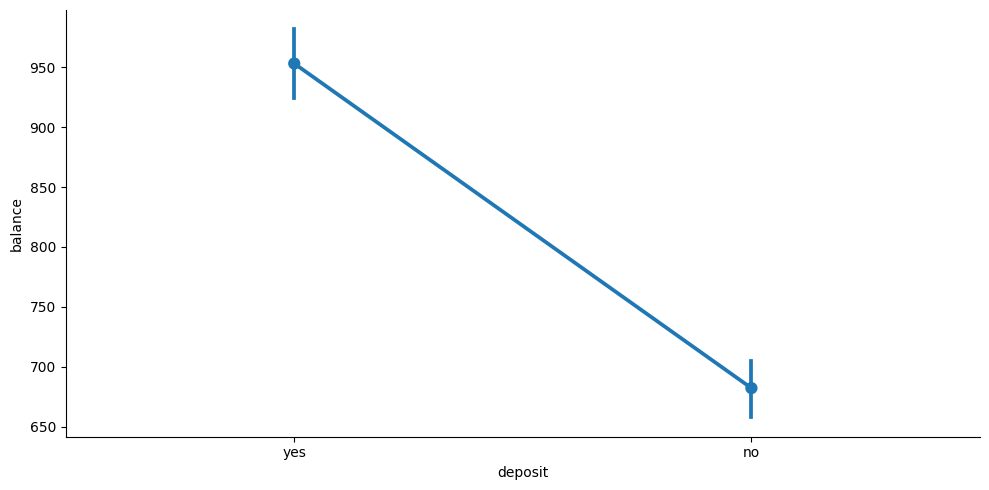

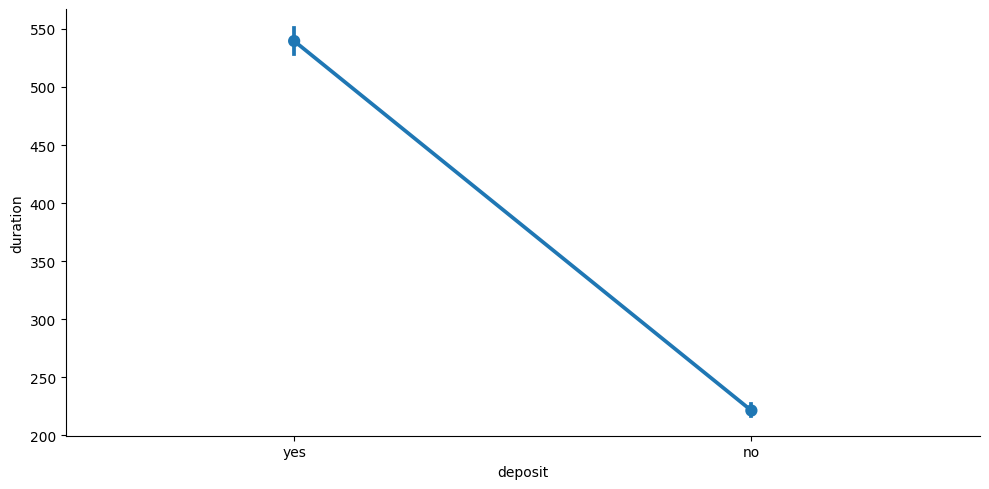

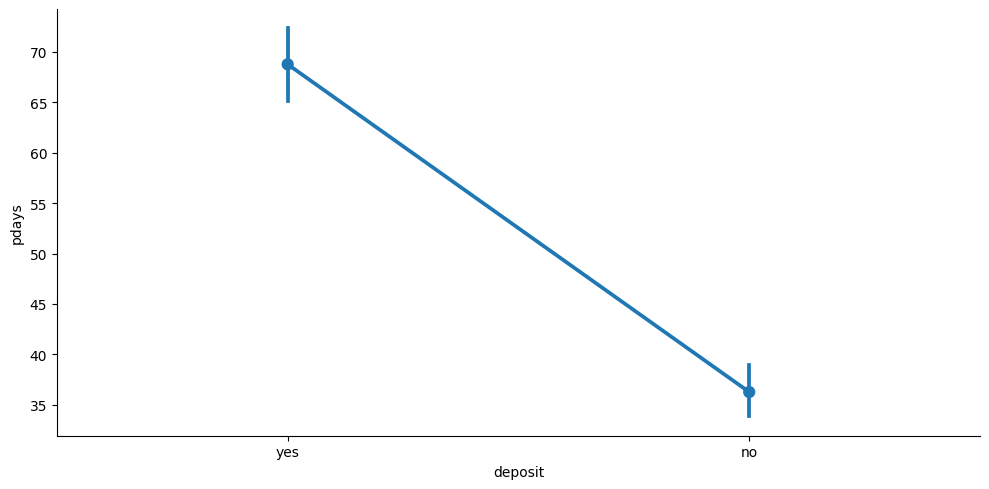

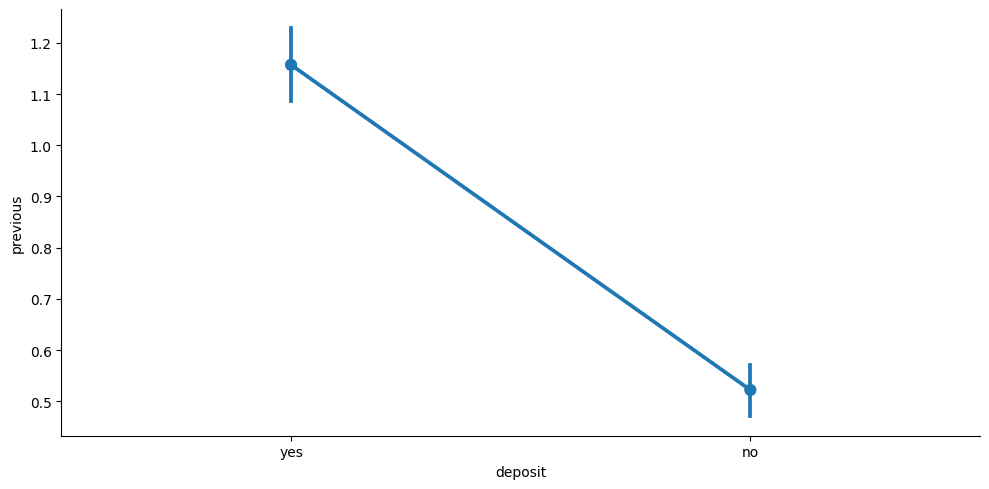

In [80]:
# график для наиболее выраженных зависимостей на депозит
for i, col in enumerate(['balance', 'duration', 'pdays', 'previous']):
    plt.figure(i)
    sns.catplot(y=col, x='deposit', data=df, kind='point', aspect=2)

<AxesSubplot: xlabel='deposit', ylabel='balance'>

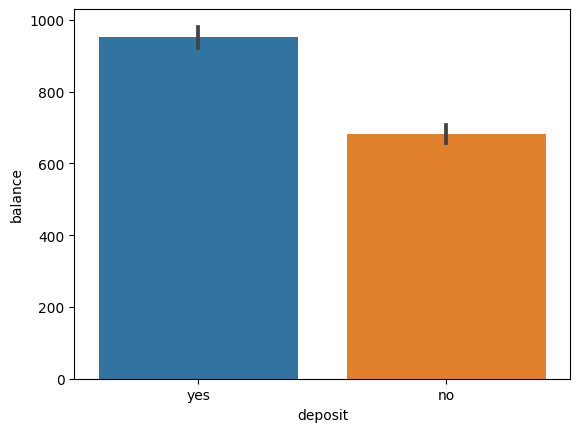

In [81]:
# влияние баланса на наличие депозита
sns.barplot(x='deposit', y='balance', data=df)

Вывод: *Количество клиентов, имеющих депозит, обладают большим балансом, что позволяет делать накопления и формировать депозит. Соответственно, зависимость наличия депозита от баланса прямопропорциональная.*

Зависимость баланса от различных факторов.

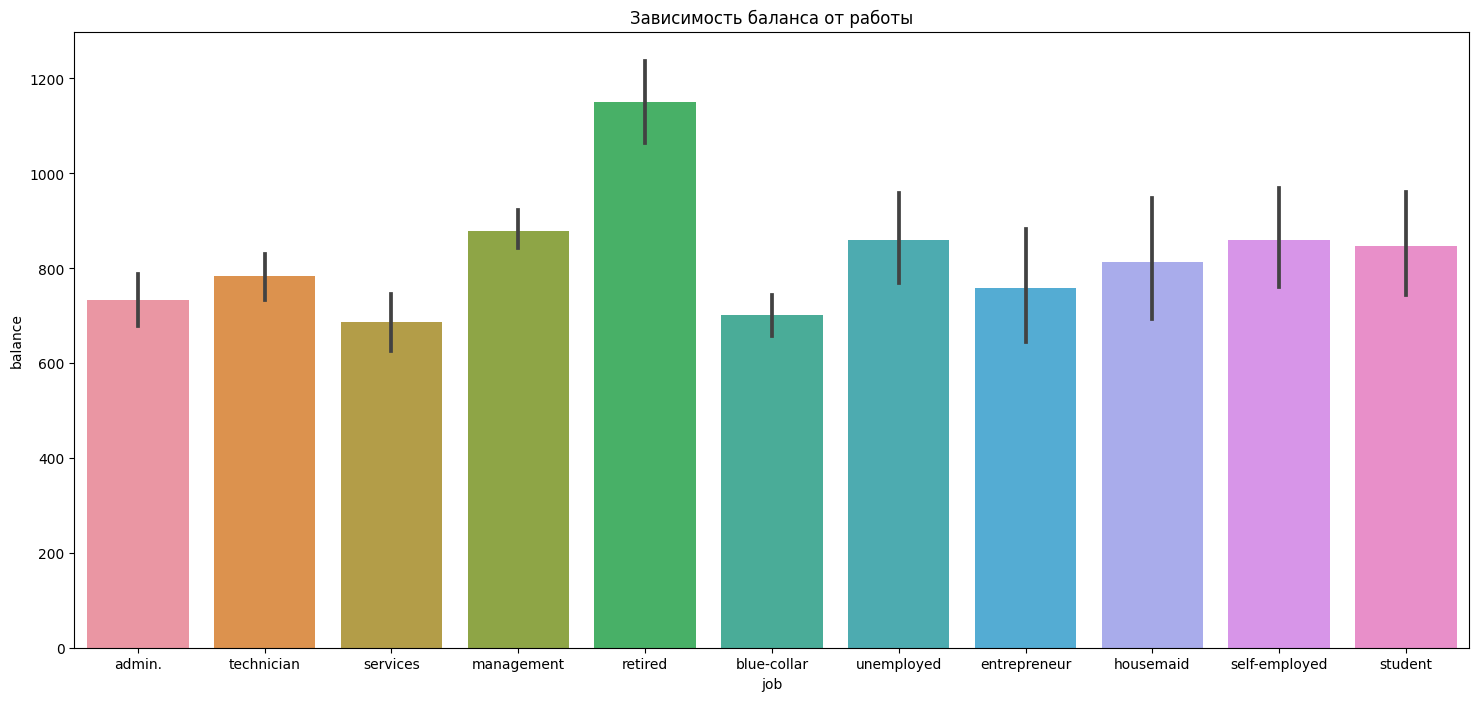

In [82]:
# зависимость от типа работы
fig = plt.figure(figsize=(18, 8))
g = sns.barplot(
    data = df,
    x = 'job',
    y = 'balance'
)
g.set_title('Зависимость баланса от работы');

Баланс зависит от вида работы. Наибольший баланс у пенсионеров, наименьший у работников в сфере услуг.

In [83]:
# зависимость от типа работы и образования/
data = df[df['deposit']=='yes']
data = data.pivot_table('balance', index ='job', columns='education', aggfunc='mean')
data

education,primary,secondary,tertiary
job,,,
admin.,643.000000,867.162791,829.370787
blue-collar,749.020305,809.326389,670.782609
entrepreneur,563.500000,951.288462,954.040816
housemaid,1157.586957,898.529412,1168.263158
management,1053.421053,1142.834437,1033.756477
retired,1347.400000,1163.201031,1414.443182
self-employed,457.000000,712.609756,1102.758621
services,852.703704,768.538721,787.952381
student,885.857143,810.346154,996.000000


Text(0.5, 1.0, 'Зависимость баланса от работы и образования')

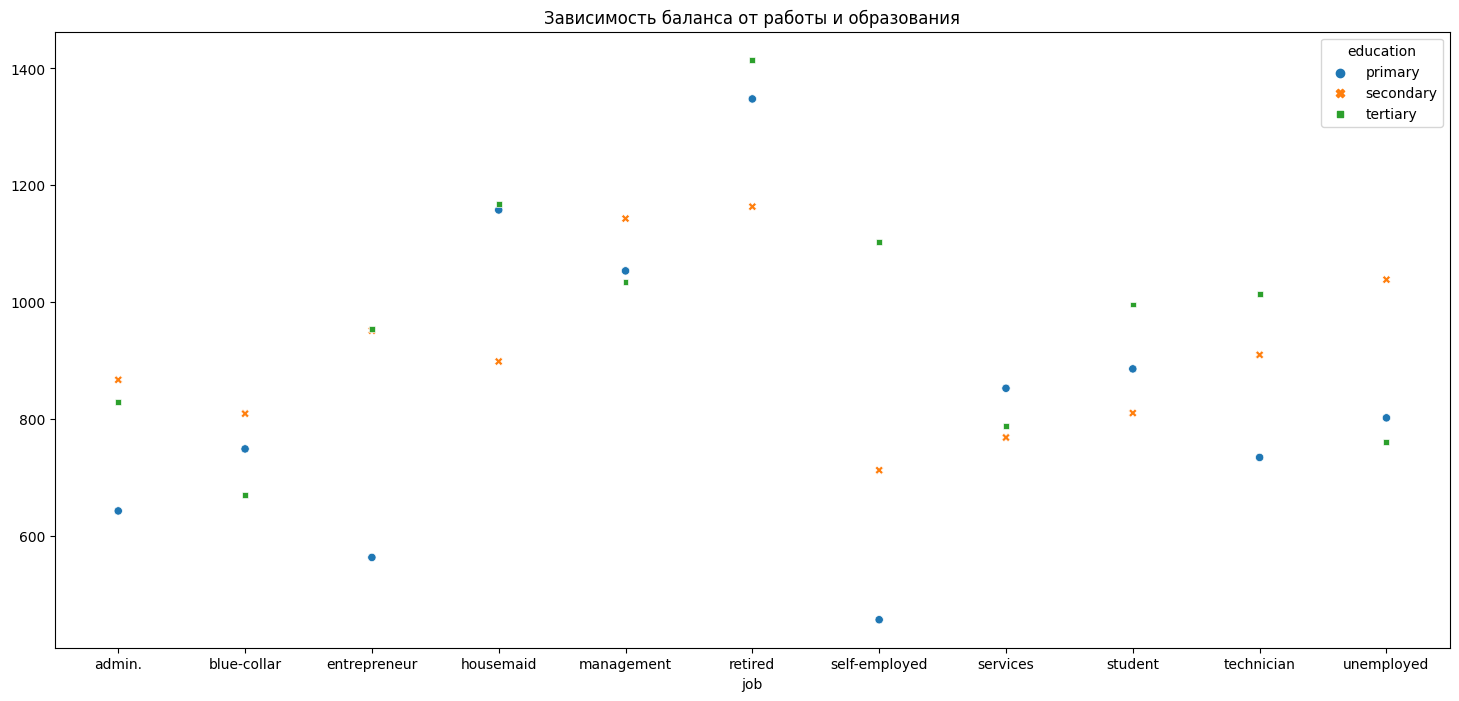

In [84]:
fig = plt.figure(figsize=(18, 8))
g = sns.scatterplot(data)
g.set_title('Зависимость баланса от работы и образования')

*Не во всех сферах деятельности прямая прямопорциональная зависимость баланса от уровня образования.*

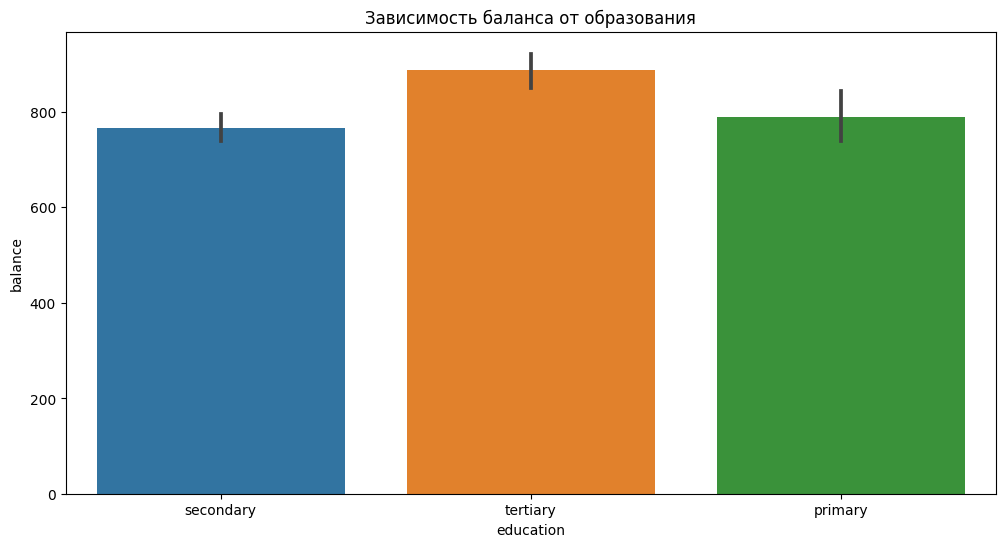

In [85]:
fig = plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data = df,
    x = 'education',
    y = 'balance'
)
barplot.set_title('Зависимость баланса от образования');

*Наблюдается влияние образования на баланс, клиенты с высшим образованием имеют больший баланс. У клиентов со средним образованием баланс ниже, чем у тех, кто имеет начальное образование.*

Распределение возраста клиентов

Text(0.5, 1.0, 'Возраст клиентов банка')

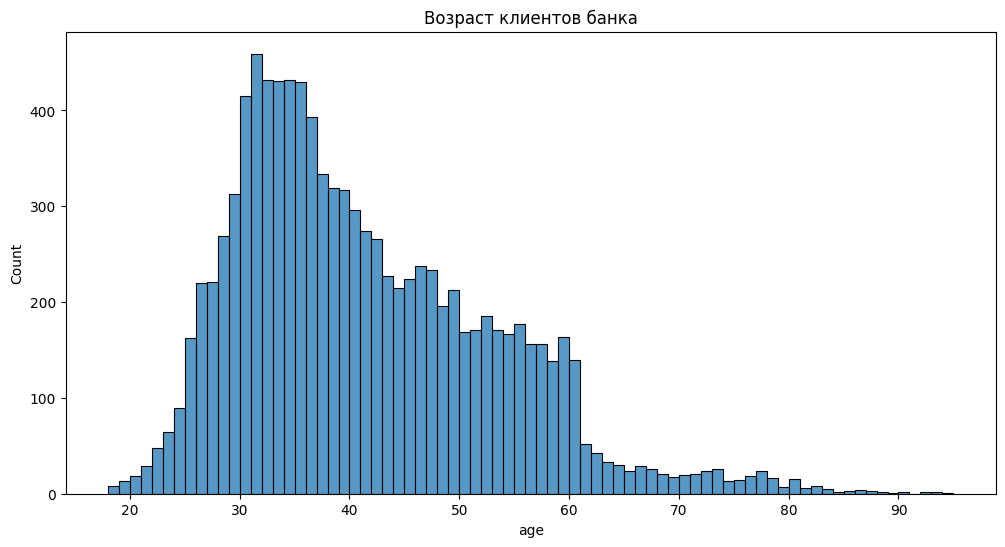

In [86]:
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(data=df['age'], binwidth=1)
g.set_title('Возраст клиентов банка')

*Данные в признаке age распределены лог-нормально. Самому младшему клиенту банка 18 лет, самому старшему 95. Медианный возраст 38 лет, средний 41.*

Text(0.5, 1.0, 'Баланс')

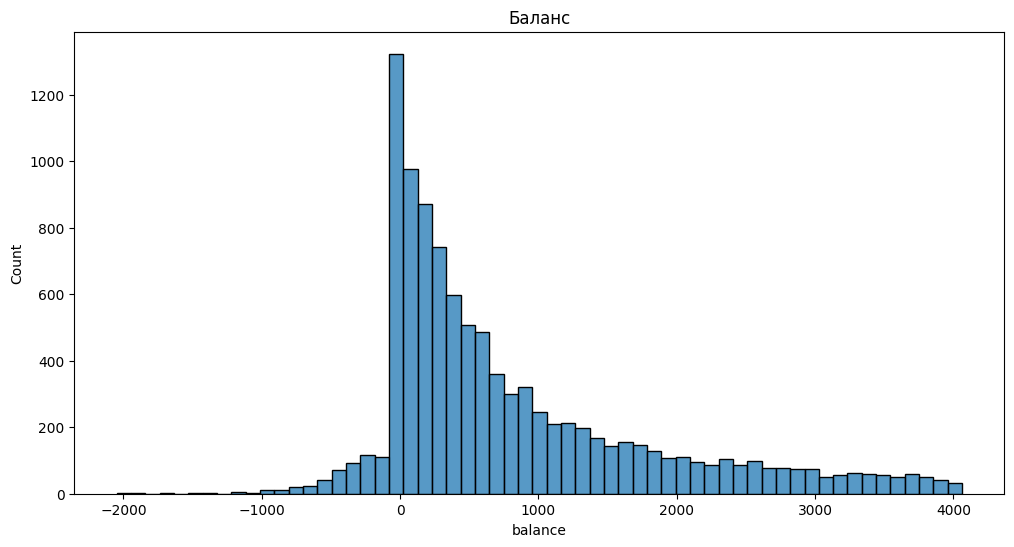

In [87]:
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(data=df['balance'])
g.set_title('Баланс')

### Задания 4 и 5

In [ ]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

### Задание 8

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [3]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [4]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna